In [27]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from plain_net.PlainNet import PlainNet
from soft_thresholding.SoftThresholdNet import SoftThresholdNet
from L1_regularization.L1RegularizationNet import L1RegularizationNet
from dynamic_sparse_reparameterization.DynamicSparseReparameterizationNet import DynamicSparseReparameterizationNet
from magnitude_pruning.MagnitudePruning import MagnitudePruningNet

from utils import load_data, load_models

In [28]:
# Load data
dataset = "alu" # alu or duffing
train_loader, test_loader, val_loader = load_data(f"data/{dataset}")
test_data = test_loader.dataset.y
t = torch.linspace(0, test_loader.dataset.DT * len(test_data)/60/60, len(test_data))

In [54]:
test_set_size = 4999
test_set_number = 1
x_test = test_loader.dataset.x_non_norm[:4999]
t = torch.linspace(0, test_loader.dataset.DT * len(x_test)/60/60, len(x_test))

In [65]:
path = "models/alu/soft_thresholding/l1/model_l1" # plain, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning

models = load_models(path, n_models=10)

In [66]:
predictions = []
for model in models:
    prediction = torch.zeros_like(x_test).detach()
    prediction[:, 8:] = x_test[:, 8:]
    prediction[:3] = x_test[:3]
    predictions.append(prediction.detach())

In [67]:
dt = test_loader.dataset.DT
y_std = test_loader.dataset.y_std
y_mean = test_loader.dataset.y_mean
x_std = test_loader.dataset.x_std
x_mean = test_loader.dataset.x_mean

for model, prediction in zip(models, predictions):
    for i in range(3, len(prediction)):
        input = (prediction[i-1] - x_mean) / x_std
        x_dot = model(input) * y_std + y_mean
        prediction[i, :8] = prediction[i-1, :8] + x_dot * dt

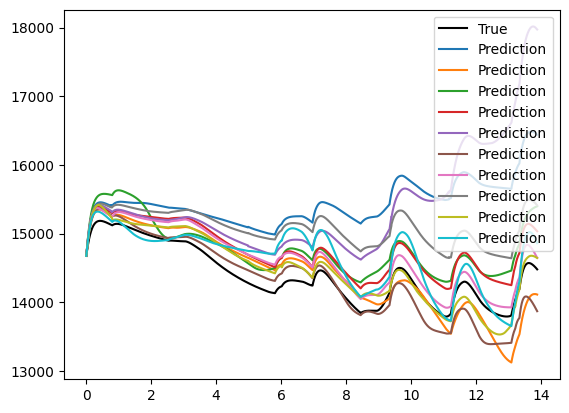

In [68]:
state = 3
steps = 4999 # Max 4999

plt.plot(t[:steps], x_test[:steps, state], label="True", color="black")
for prediction in predictions:
    plt.plot(t[:steps], prediction[:steps, state].detach(), label="Prediction")
plt.legend()
plt.show()

In [52]:
mean_prediction = torch.zeros_like(x_test).detach()
for prediction in predictions:
    mean_prediction += prediction
mean_prediction /= len(predictions)

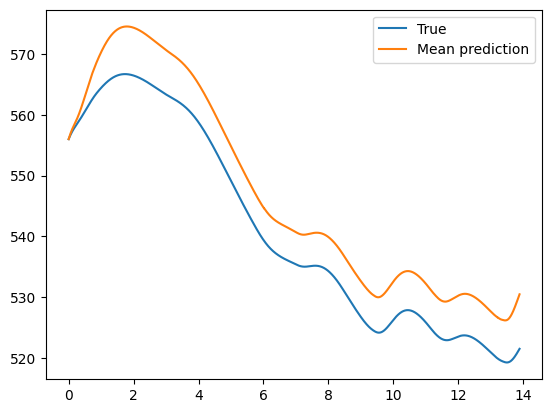

In [35]:
state = 7
steps = 5000

plt.plot(t[:steps], x_test[:steps, state], label="True")
plt.plot(t[:steps], mean_prediction[:steps, state].detach(), label="Mean prediction")
plt.legend()
plt.show()